In [3]:
from main import Simplify
import os
import json
import re
import sys
import time

import cv2
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from aegan import AEGAN

BATCH_SIZE = 32
LATENT_DIM = 32

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = tv.transforms.Compose([
    tv.transforms.RandomAffine(0, translate=(5 / 96, 5 / 96), fill=(255, 255, 255)),
    # tv.transforms.ColorJitter(hue=0.5),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    Simplify(),
    # tv.transforms.ToTensor(),
    # tv.transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])
dataset = ImageFolder(
    root="data_cleared",
    transform=transform
)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=1,
                        drop_last=True
                        )

noise_fn = lambda x: torch.randn((x, LATENT_DIM), device=device)

gan = AEGAN(
    LATENT_DIM,
    noise_fn,
    dataloader,
    device=device,
    batch_size=BATCH_SIZE,
    colors_cnt=5,
    channels_cnt=5,
)

In [4]:
# best is 349
gan.load(os.path.join("data_simplified_linear_upsampling_4colors_stolen_discriminator_results", "checkpoints"), 949)

In [5]:
def restore_simplified(x, threshold=0.5, black_threshold=0.1):
    black, yellow, blue, red, white = torch.split(x, [1, 1, 1, 1, 1], dim=0)

    def color(t, r, g, b):
        return torch.cat([t * r, t * g, t * b], dim=0)

    return color(white > threshold, 1, 1, 1) +\
           color(red > threshold, 1, 0, 0) +\
           color(blue > threshold, 99 / 255, 111 / 255, 221 / 255) +\
           color(yellow > threshold, 254 / 255, 215 / 255, 16 / 255) +\
           color(black > black_threshold, 0, 0, 0)

In [204]:
# black, yellow, blue, red, white = torch.split(generated, [1, 1, 1, 1, 1], dim=0)
# black.median()

In [6]:
seed = noise_fn(100)

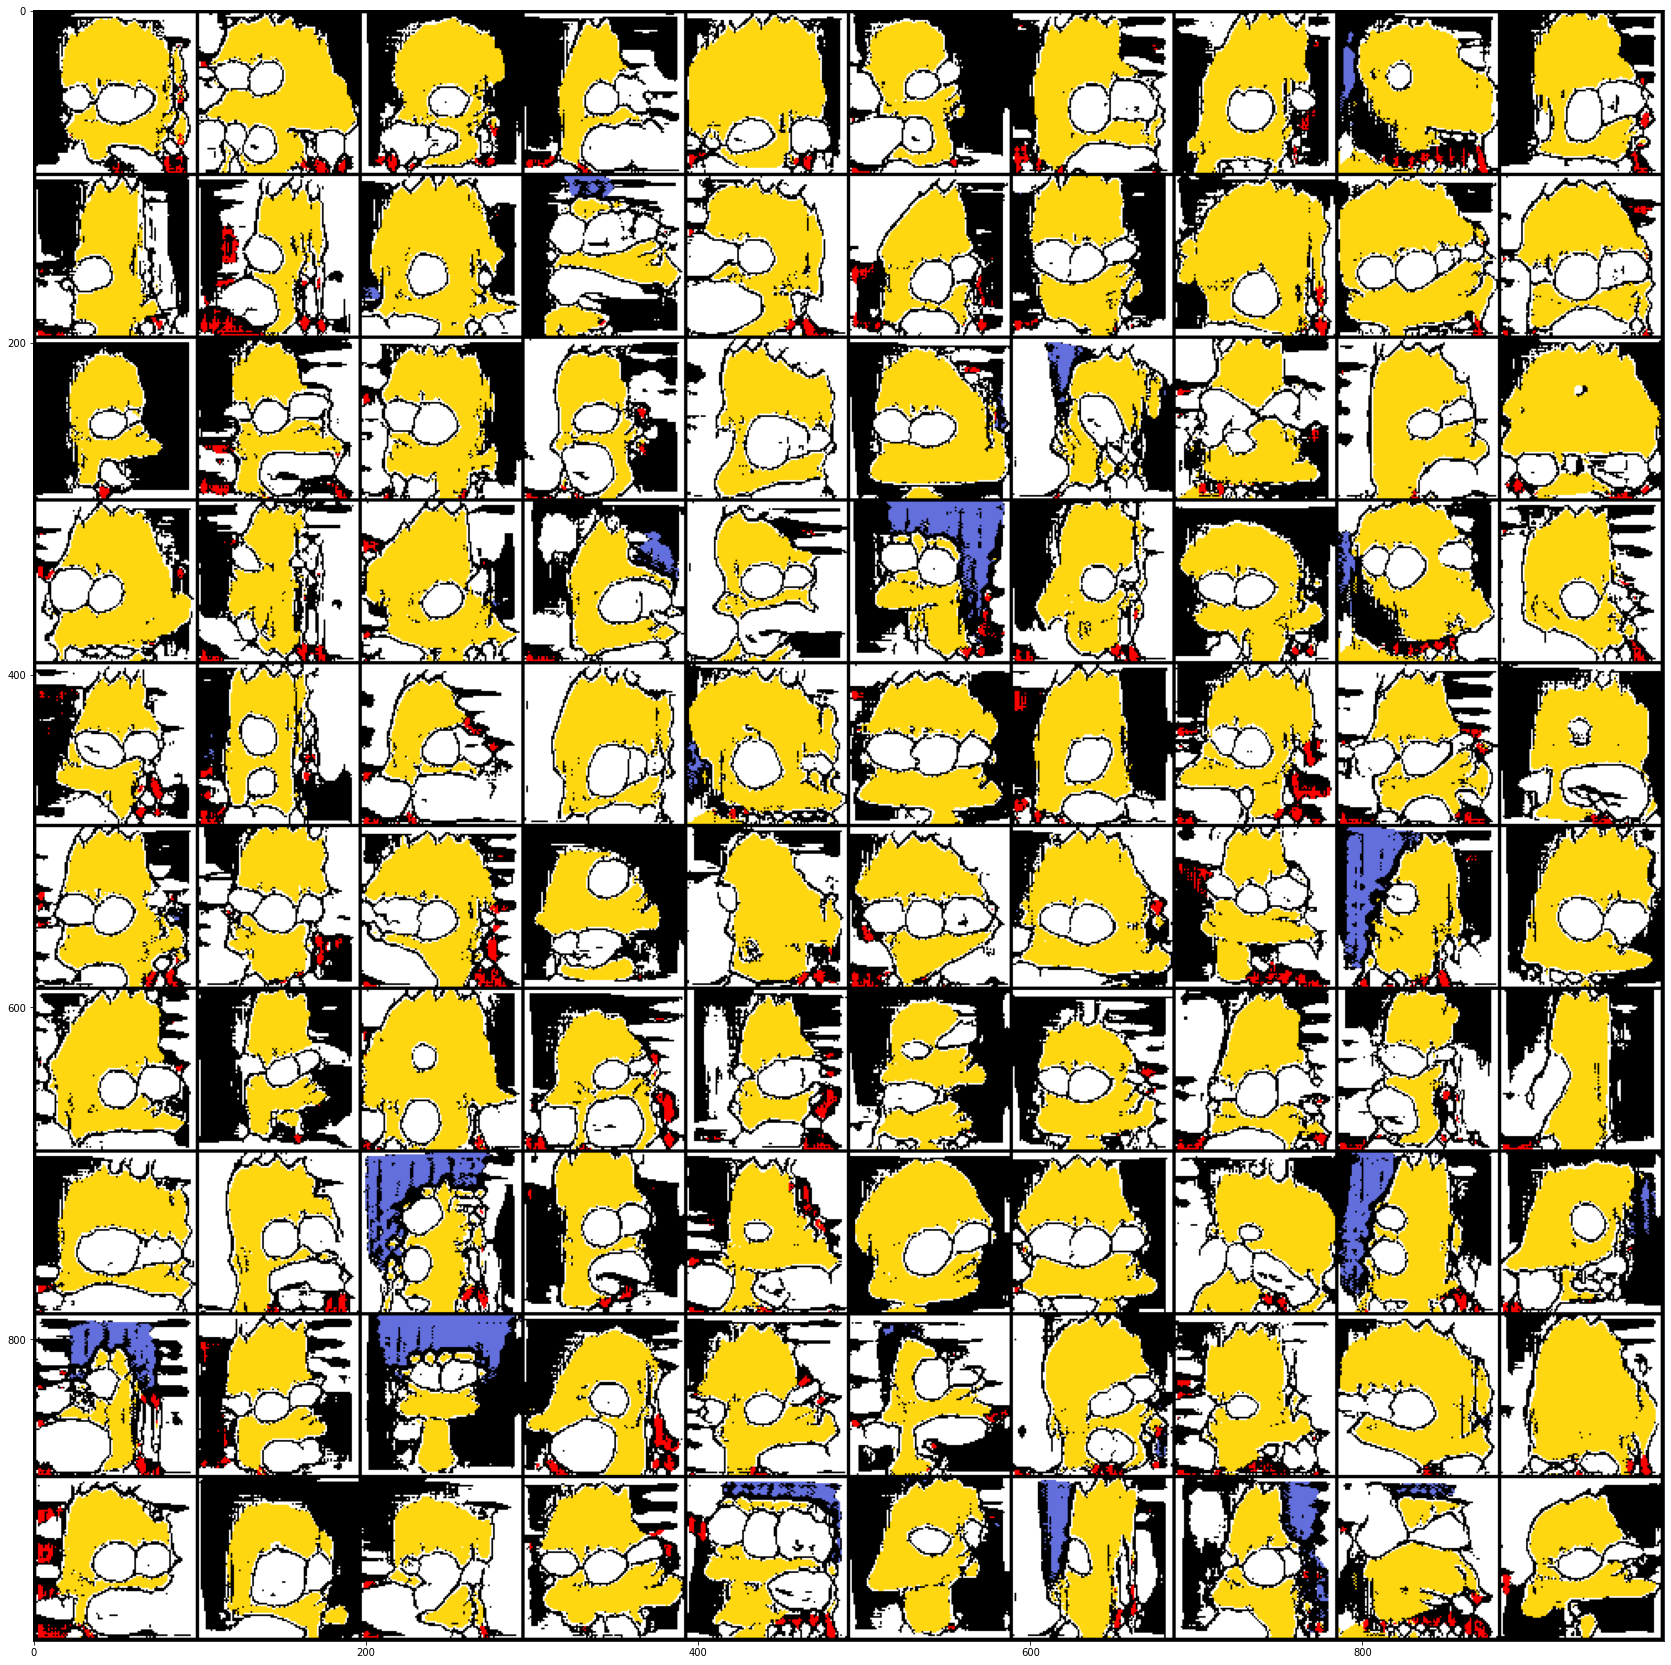

In [7]:
gan.generator.eval()
with torch.no_grad():
    generated = gan.generator(seed)

# generated = generated[0]
generated = tv.utils.make_grid(generated, normalize=True, nrow=10, ncol=10)

# for thresh in np.linspace(0, 1, 10):
def to_image(generated):
    restored = restore_simplified(generated, threshold=0.9)
    restored = restored.cpu().numpy().transpose([1, 2, 0])
    restored = (restored * 255).astype(np.uint8)
    # restored = cv2.fastNlMeansDenoisingColored(restored, None, 10, 10, 7, 21)
    return restored

restored = to_image(generated)
plt.figure(figsize=(30, 30))
plt.imshow(restored)
plt.show()

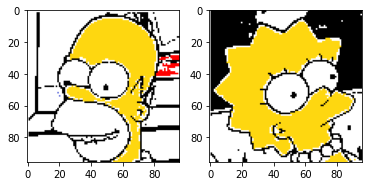

In [8]:
data_iter = iter(dataloader)
images = next(data_iter)[0]
img1 = images[0][None, :, : ,:]
img2 = images[1][None, :, : ,:]
# img2 = next(data_iter)[0]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(to_image(img1[0]))
ax2.imshow(to_image(img2[0]))
plt.show()

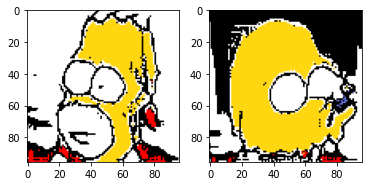

In [9]:
gan.encoder.eval()

# img1, img2 = img1[None, :, : ,:], img2[None, :, : ,:]

with torch.no_grad():
    img1_latent = gan.encoder(img1)
    img2_latent = gan.encoder(img2)
    img1_restored = gan.generator(img1_latent)
    img2_restored = gan.generator(img2_latent)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(to_image(img1_restored[0]))
ax2.imshow(to_image(img2_restored[0]))
plt.show()

In [228]:
img1_latent, img2_latent

(tensor([[ 4.2556e-01, -5.2044e-01, -2.7219e-01,  5.8710e-01,  1.0507e+00,
           1.7995e-02, -2.2006e-01, -1.1399e+00,  1.4872e-01, -4.5363e-01,
           7.2140e-01, -6.9467e-01, -5.0453e-02, -1.0221e+00,  3.8102e-01,
           1.6171e-01,  5.9620e-02,  8.8514e-01,  2.9493e-01,  3.5733e-01,
           1.7750e-01, -1.6113e+00,  1.8191e-01, -9.5005e-01, -1.8245e-01,
           1.0542e+00, -9.7239e-04,  5.2166e-02,  9.6929e-01, -2.6829e-01,
           5.0863e-01, -6.2948e-01]]),
 tensor([[-0.6775, -0.3653,  0.9984, -0.3104, -0.5331,  0.8751,  0.6662,  0.0866,
           0.3042, -1.1332, -0.1167, -0.9692, -0.1629,  0.6070,  0.3763,  0.1399,
          -0.4034,  0.5191, -0.0666, -0.6178,  0.4894, -0.3573, -0.3358,  0.3114,
          -0.0218, -0.8182,  0.5159,  0.9545,  0.2596, -0.2492,  0.1564, -0.2530]]))

In [11]:
from tqdm import tqdm

steps_cnt = 10
images = []

img1_latent_copy = img1_latent.clone()
with torch.no_grad():
    for i, (latent1_value, latent2_value) in tqdm(enumerate(zip(img1_latent[0], img2_latent[0]))):
        # print(f"{i}", end="\r")
        for step_idx in range(steps_cnt):
            img1_latent_copy[0][i] += (latent2_value - latent1_value) / steps_cnt
            step_img = gan.generator(img1_latent_copy)
            step_img = to_image(step_img[0])
            step_img = Image.fromarray(step_img)
            images.append(step_img)

32it [00:36,  1.14s/it]


In [12]:
images[0].save("5colors_interpolation_steps.gif", save_all=True, append_images=images[1:], duration=50, loop=0)

In [13]:

steps_cnt = 300
images = []

img1_latent_copy = img1_latent.clone()
with torch.no_grad():
    for step_idx in tqdm(range(steps_cnt)):
        img1_latent_copy += (img2_latent - img1_latent) / steps_cnt
        step_img = gan.generator(img1_latent_copy)
        step_img = to_image(step_img[0])
        step_img = Image.fromarray(step_img)
        images.append(step_img)

100%|██████████| 300/300 [00:40<00:00,  7.32it/s]


In [237]:
len(images)

320

In [14]:
images[0].save("5colors_interpolation_straight.gif", save_all=True, append_images=images[1:], duration=50, loop=0)